# Memprediksi Kanker (Malignant) menggunakan SVM

Pada Jupyter notebook ini, kamu akan menggunakan SVM (Support Vector Machines) untuk membuat dan melatih model menggunakan data cell manusia, dan akan mengklasifikasi cell apakah cell tersebut masih bertipe benign (tumor jinak) atau sudah menjadi kanker ganas (malignant)

SVM bekerja dengan cara mapping data ke high-dimensional feature space, sehingga data points bisa dikategorisasi walaupun data tidak terpisah secara linear. SVM akan mengeneraasi separator antara kategori dan kemudian data akan di transformasi dimana separator digambarkan sebagai hyperplane. Menggunakan hyperplane, karekteristik dari data yang baru dapat digunakan untuk memprediksi group dimana data tersebut diklasifikasikan.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import preprocessing # import preprocessing
from sklearn.model_selection import train_test_split # import train_test_split
from sklearn.metrics import f1_score, accuracy_score # import f1_score, accuracy_score

##  Load data dari cell_samples.csv

Contoh yang digunakan adalah berdasarkan dari dataset yang tersedia secara publik dari UCI Machine Learning Repository. Dataset tersebut terdiri dari beberapa ratus sample records cell manusia, setiap cell mempunyai nilai dari beberapa set dari karakteristis cell. 
Attribute/Field yang ada pada dataset adalah sebagai berikut:

|Field name|Description|
|--- |--- |
|ID|ID|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

## Load Data From CSV File  

In [4]:
# Import data from data folder 
cell_df = pd.read_csv('GenAI Pertemuan 2 Latihan DTSense_Support_Vector_Machine\data\input\cell_samples.csv') # read_csv data cell_samples
cell_df.head() # intip 5 data teratas

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Field ID menunjukan ID dari pasien. Karakteristik dari sample cell dari setiap pasien ada pada field Clump sampai Mit. Field tersebut mempunyai nilai dari 1 sampai 10, dimana semakin kecil nilai / mendekati 1, semakin mendekat ke "benign"/Tumor jinak.

Field Class memiliki categorical value dari diagnosis, yang dikonfirmasi dari beberapa prosedur medis. Diagnosis menunjukkan apakah karakteristik bersifat benign (value=2) atau malignant (value=4)

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Kita bisa melihat distribusi dari kelas berdasarkan Clump thickness dan Uniformity dari ukuran cell:

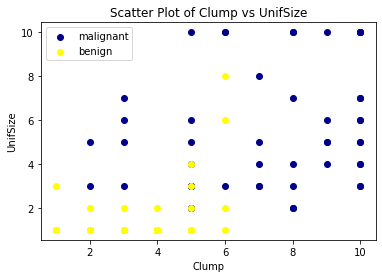

In [5]:
# Subset column class dan lakukan plotting dengan jenis scatter untuk melihat relasi Clump dan UnifSize

# Create a figure and axis
fig, ax = plt.subplots()

# Plot malignant samples
ax.scatter(cell_df[cell_df['Class'] == 4]['Clump'].head(50), 
           cell_df[cell_df['Class'] == 4]['UnifSize'].head(50), 
           color='DarkBlue', label='malignant')

# Plot benign samples
ax.scatter(cell_df[cell_df['Class'] == 2]['Clump'].head(50), 
           cell_df[cell_df['Class'] == 2]['UnifSize'].head(50), 
           color='Yellow', label='benign')

# Create legend
plt.legend(loc='best')

# Add labels and title
plt.xlabel('Clump')
plt.ylabel('UnifSize')
plt.title('Scatter Plot of Clump vs UnifSize')

# Show the plot
plt.show()

## Data preprocessing and selection

Kemudian kita bisa melihat tipe column apa aja yang ada dari data:

In [6]:
cell_df.dtypes # check dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Bisa kita lihat bahwa column **BareNuc** mempunyai nilai yang sifatnya non-numerik (object). Sebelum kita drop rows, kita bisa lakukan statistical EDA.

In [7]:
cell_df.describe() # gunakan describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [8]:
# Berapa banyak rows yang bukan numerik pada **BareNuc** column? Dengan melakukan check jenis data yang not null
# gunakan errors='coerce', jika dia bersifat non-numerik akan diconvert menjadi NaN
(pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()).value_counts()

cell_df.groupby(pd.to_numeric(cell_df['BareNuc'], errors='coerce').isnull()).count()
 # gunakan groupby pada column tersebut dan kita bisa lihat jumlahnya


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
BareNuc,,,,,,,,,,,
False,683,683,683,683,683,683,683,683,683,683,683
True,16,16,16,16,16,16,16,16,16,16,16


In [9]:
# Drop rows yang mempunyai label ? menggunakan coerce untuk menjadikan nilai tersebut menjadi NaN
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()] # coerce, invalid parsing, become NaN
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [10]:
# Subset column yang relevant untuk menjadi variable prediktor
X = cell_df[['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,1000025,5,1,1,1,2,1,3,1,1
1,1002945,5,4,4,5,7,10,3,2,1
2,1015425,3,1,1,1,2,2,3,1,1
3,1016277,6,8,8,1,3,4,3,7,1
4,1017023,4,1,1,3,2,1,3,1,1


In [11]:
print(X.shape , X.columns)

(683, 10) Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit'],
      dtype='object')


In [12]:
print(cell_df.shape, cell_df.columns)

(683, 11) Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')


Selanjutnya kita mau membuat model untuk memprediksi jenis kelas benign (=2) atau malignant (=4).

Karena field ini bisa mempunyai satu dari 2 possible values, kita bisa mengubah measurement level ke tipe int dan masukkan kedalam array untuk membantu memudahkan proses training. 

In [13]:
# Subset column "Class" untuk menjadi variable response
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train-Test dataset

Selanjutnya kita split dataset menjadi training dan test set:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=4) # Gunakan train_test_split dengan training size 80% dan random state
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 10) (546,)
Test set: (137, 10) (137,)


# Modeling (SVM with Scikit-learn)

Algoritma SVM menawarkan beberapa pilihan dari fungsi kernel untuk melakukan process training. Secara garis besar, proses menghubungkan data / mapping data ke higher dimensional space disebut kernelling. Fungsi matematis digunakan untuk transformasi untuk menjadi kernel ada beberapa tipe, seperti:

    1. Linear
    2. Polynomial
    3. Radial basis function (RBF)
    4. Sigmoid
    
Setiap dari fungsi tersebut mempunyai karakteristikny sendiri, mempunyai pros and cons, dan rumus yang berbeda. Tidak ada konsep yang mudah fungsi mana yang bisa memberikan performa terbaik. Biasanya kita perlu melakukan experimental untuk menggunakan fungsi yang berbeda untuk merubah dan komparasi hasil.
Untuk lab sekarang, kita bisa menggunakan RBF.

In [15]:
from sklearn import svm # panggil svm

clf = svm.SVC(kernel='rbf', gamma=0.001) # panggil SVC dengan hyperparameter gamma 0.1 - 0.0001
# bandingkan mana yang lebih baik 
clf.fit(X_train, y_train) # panggil fit dan masukkan X_train dan y_train

SVC(gamma=0.001)

Setelah melakukan fitted, model kemudian bisa digunakan untuk memprediksi nilai yang baru:

In [16]:
y_pred = clf.predict(X_test) # lakukan predict dengan menggunakan data X_test
y_pred[0:5] # lihat 5 hasil prediksi diawal dengan teknik slicing

array([2, 2, 2, 4, 2])

## Evaluation

In [17]:
from sklearn.metrics import classification_report, confusion_matrix # panggil classification_report, confusion_matrix
import itertools

In [18]:
# Fungsi dibawah hanya untuk membuat plotting confusion matrix lebih fancy.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.65      0.94      0.77        90
           4       0.17      0.02      0.04        47

    accuracy                           0.63       137
   macro avg       0.41      0.48      0.40       137
weighted avg       0.48      0.63      0.52       137



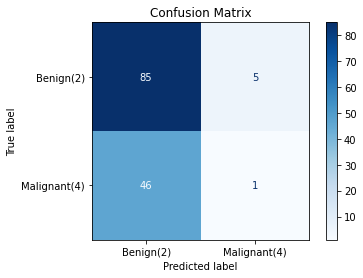

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Compute confusion matrix dengan menggunakan data y_test dan y_pred
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 4])
np.set_printoptions(precision=2)

# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Benign(2)', 'Malignant(4)'])

# Plot non-normalized confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')  # Set the title here
plt.show()  # Display the plot

Kita juga bisa menggunakan f1-score dan accuraxy dari sklearn:

In [20]:
# F1-score on test set
print("F1-score:", f1_score(y_test, y_pred, average='weighted')) # Gunakan f1_score(y_test, y_pred, average='weighted'))

# Accuracy score on test set
print("Accuracy:", accuracy_score(y_test, y_pred)) # Gunakan accuracy_score(y_test, y_pred))

F1-score: 0.5182799572002161
Accuracy: 0.6277372262773723


## Exercise

#### 1. Silahkan membuat ulang model, namun menggunakan linear kernel dan gamma yang berbeda, dan lakukan komparasi perubahan akurasi dengan fungsi kernel yang baru, kombinasi parameter apa yang memberikan hasil terbaik?

In [21]:
# Your code!
from sklearn import svm # panggil svm

clf = svm.SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

clf.fit(X_train, y_train) # panggil fit dan masukkan X_train dan y_train

SVC(kernel='linear')

In [22]:
y_pred = clf.predict(X_test) # lakukan predict dengan menggunakan data X_test
y_pred[0:5] # lihat 5 hasil prediksi diawal dengan teknik slicing

array([2, 2, 2, 2, 2])

              precision    recall  f1-score   support

           2       0.68      0.99      0.81        90
           4       0.83      0.11      0.19        47

    accuracy                           0.69       137
   macro avg       0.76      0.55      0.50       137
weighted avg       0.73      0.69      0.59       137



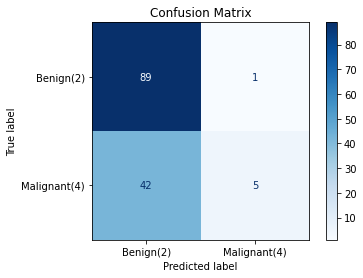

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Compute confusion matrix dengan menggunakan data y_test dan y_pred
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 4])
np.set_printoptions(precision=2)

# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Benign(2)', 'Malignant(4)'])

# Plot non-normalized confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')  # Set the title here
plt.show()  # Display the plot

In [24]:
# F1-score on test set
print("F1-score:", f1_score(y_test, y_pred, average='weighted')) # Gunakan f1_score(y_test, y_pred, average='weighted'))

# Accuracy score on test set
print("Accuracy:", accuracy_score(y_test, y_pred)) # Gunakan accuracy_score(y_test, y_pred))

F1-score: 0.5938438854825351
Accuracy: 0.6861313868613139


#### 2. Lakukan training dengan menggunakan logistic regression pada dataset yang sama. Bagaimana performa model tersebut dibandingkan dengan SVM?

In [25]:
# Your code!
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)

In [26]:
y_lr_pred = log_reg.predict(X_test)

              precision    recall  f1-score   support

           2       0.68      0.99      0.81        90
           4       0.83      0.11      0.19        47

    accuracy                           0.69       137
   macro avg       0.76      0.55      0.50       137
weighted avg       0.73      0.69      0.59       137



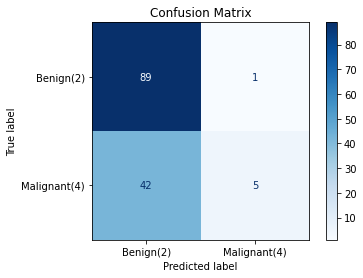

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Compute confusion matrix dengan menggunakan data y_test dan y_pred
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 4])
np.set_printoptions(precision=2)

# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Benign(2)', 'Malignant(4)'])

# Plot non-normalized confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')  # Set the title here
plt.show()  # Display the plot

In [28]:
# F1-score on test set
print("F1-score:", f1_score(y_test, y_pred, average='weighted')) # Gunakan f1_score(y_test, y_pred, average='weighted'))

# Accuracy score on test set
print("Accuracy:", accuracy_score(y_test, y_pred)) # Gunakan accuracy_score(y_test, y_pred))

F1-score: 0.5938438854825351
Accuracy: 0.6861313868613139
